## Multilayer Perceptron

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(18937)

## Artificial neuron
We can define parameters inside the model using tf.Variable(). They will be initialized using a truncated normal distribution. Then define the concept of a neuron based of its mathematical formula. 

The most basic units within tensorflow are tf.constant, tf.variable, and tf.placeholder. They are the data structures that hold multidimensional arrays in the tensorflow framework. 

The difference between a tf.variable and a tf.placeholder is that tf.placeholders are variables that can be assigned by a "driver" program (a script that invokes tensorflows's API and runs the training). Placeholders will always need to be fed some external information.

In [2]:
Weights = lambda shape: tf.Variable(tf.truncated_normal(shape, seed = 0x3fe69))

In [4]:
Biases = lambda shape: tf.Variable(tf.truncated_normal(shape, seed = 0xac5b0))

## Generate two-blob data

In [5]:
from sklearn.datasets.samples_generator import make_blobs

In [24]:
X, y = make_blobs(n_samples = 600, centers = 2, n_features = 2, random_state = 76533)
X = scale(X, with_std = False) # Center X

In [25]:
X[0:10]

array([[-0.84541372,  1.75217933],
       [ 2.18441599, -0.22926311],
       [-2.63337738,  1.94960967],
       [-1.45301404,  0.82836443],
       [ 2.55295548, -0.5205783 ],
       [ 1.88958366, -1.78663552],
       [ 1.59338412, -2.48623633],
       [ 2.00876472, -0.96084028],
       [-0.99886226,  1.01631157],
       [ 3.15399718, -2.46738279]])

In [26]:
y[0:10]

array([1, 0, 1, 1, 0, 0, 0, 0, 1, 0])

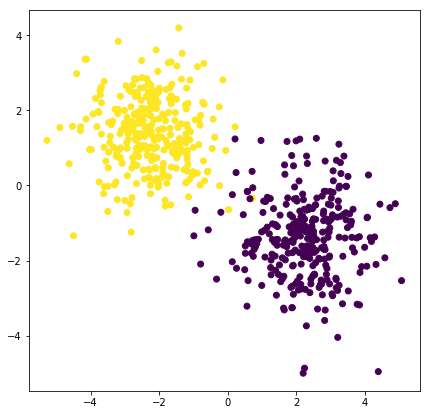

In [27]:
plt.figure(figsize = (7,7))
plt.scatter(X[:,0], X[:, 1], c = y)

## Fit one neuron
Training one neuron to classify the two-blobs data. This sections aims to demonstrate the workflow of building and training a model using tensorflow. 


### Step 1: Input/Output
During training, we should use tf.placeholder to "feed" information into the neural network model. In this example, the model will be fed with features and labels for supervised learning. 

In [28]:
features = tf.placeholder("float", (None, X.shape[1]))
labels = tf.placeholder("float", (None, ))

### Step 2: Computation graph
This is the part where you describe the dataflow. A graph contains a set of tf.operations objects, which represent units of computation. 

And tf.tensor objects, which represents the units of data that flow between operations. 

* https://www.tensorflow.org/api_docs/python/tf/Graph
* https://www.tensorflow.org/api_docs/python/tf/Tensor
* https://www.tensorflow.org/api_docs/python/tf/Operation

Tensorflow operations are callable objects that take tensors and return tensors. Tensorflow tensors are in fact lazy data structures representing multidimensional arrays that won't hold values until evaluation. 

The following cell defines a graph containing one neuron as well as the loss function. In addition, the backpropagation is also defined by optimizer and training as part of the graph. 

In [31]:
def one_neuron_graph():
    
    # create a single neuron for this model. 
    neuron = lambda x: tf.sigmoid(tf.add(tf.matmul(x, Weights((X.shape[1], 1))), Biases((1, ))))
    
    # predictions ar emade by this neuron
    predictions = neuron(features)
    
    # loss function to be optimized. We use mean squared error. 
    loss = tf.losses.mean_squared_error(labels, tf.squeeze(predictions))
    
    # an optimzer defines the operation for updating parameters within the model
    # learning rate = 0.5
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    
    # training is defined as minimizing the loss function using gradient descent. 
    training = optimizer.minimize(loss)
    
    return [training, loss, predictions]

### Step 3: Run computation graph with tensorflow session

In [35]:
class OneNeuron(object):
    def __init__(self, session):
        self.context = [session] + one_neuron_graph()
        
    def fit(self, X, y, N_BATCH = 32):
        sess, training, loss, _ = self.context
        
        # an array recording training loss
        training_loss = []
        
        # training loop
        for epoch in range(10):
            epoch_loss = []
            for i in range(0, X.shape[0], N_BATCH):
                _, batch_loss = sess.run([training, loss], feed_dict = {
                    features: X[i: i + N_BATCH],
                    labels: y[i: i + N_BATCH]
                })
                epoch_loss.append(batch_loss)
            training_loss.append(np.mean(epoch_loss))
            
        self.training_loss = training_loss
        
    def predict(self, X, N_BATCH = 32):
        sess, _, _, predictions = self.context
        
        y_pred = []
        for i in range(0, X.shape[0], N_BATCH):
            batch_prediction = sess.run(predictions, feed_dict = {
                features: X[i: i + N_BATCH]
            })
            y_pred.extend(batch_prediction.squeeze())
        return np.array(y_pred)

Accuracy 0.991666666667


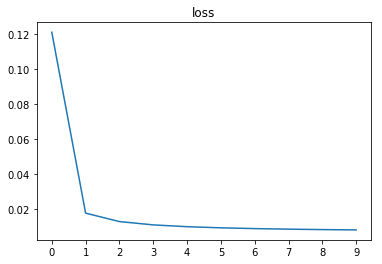

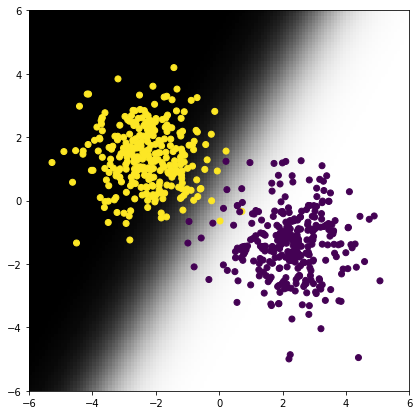

In [37]:
with tf.Session() as sess:
    
    # create one neuron model
    one_neuron = OneNeuron(sess)
    
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # training
    one_neuron.fit(X, y)
    
    # evaluation
    print("Accuracy", accuracy_score(y, one_neuron.predict(X) >= 0.5))
    
    # plot training loss
    plt.figure(figsize = (6, 4))
    plt.title("loss")
    plt.xticks(range(len(one_neuron.training_loss)))
    plt.plot(range(len(one_neuron.training_loss)), one_neuron.training_loss)
    
    # plot decision plane
    x1, x2 = np.meshgrid(np.linspace(-6, 6, 120), np.linspace(-6, 6, 120))
    Z = np.array(one_neuron.predict(np.column_stack([x1.ravel(), x2.ravel()]))).reshape(x1.shape)
    plt.figure(figsize = (7, 7))
    plt.imshow(Z, interpolation='nearest',
            extent=(x1.min(), x1.max(), x2.min(), x2.max()), vmin=0.0, vmax=1.0,
            aspect='equal', origin='lower', cmap='binary'
    )
    plt.scatter(X[:, 0], X[:, 1], c = y)

## Two-layer feedforward network
In this section, we will fit a two layer feedforward neural network on the red wine dataset and deal with some practical problems in applying neural network to a real-world dataset before we move on to more advanced models. 

### Load dataset
Load dataset from files into multi-dimensional array

In [47]:
datasource = "datasets/winequality-red.csv"
print(os.path.exists(datasource))

True


In [48]:
dataset = pd.read_csv(datasource).sample(frac = 1).reset_index(drop = True)

In [49]:
del dataset["Unnamed: 0"]

In [50]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.8,0.64,0.00,1.9,0.072,27.0,55.0,0.99620,3.31,0.63,11.0,5
1,7.1,0.59,0.01,2.5,0.077,20.0,85.0,0.99746,3.55,0.59,9.8,5
2,12.2,0.45,0.49,1.4,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5
3,10.0,0.44,0.49,2.7,0.077,11.0,19.0,0.99630,3.23,0.63,11.6,7
4,12.7,0.60,0.65,2.3,0.063,6.0,25.0,0.99970,3.03,0.57,9.9,5


In [51]:
X = scale(np.array(dataset.iloc[:, :-1]))
y = np.array(dataset["quality"])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [53]:
print("Class distribution", {i: np.sum(y == i) for i in np.unique(dataset["quality"])})

Class distribution {3: 10, 4: 53, 5: 681, 6: 638, 7: 199, 8: 18}


In [55]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


## Dense layers
Any layers that are not the output layer are referred to as hidden layers. So in this model, we will have a hidden layer and an output layer, each containing a few artificial neurons. In this model, the neurons are fully connected between layers. Therefore, these layers are called dense layers. 

Let's first define the concept of a dense layer

In [56]:
def Dense(n, activation):
    return lambda x: activation(
        tf.matmul(x, Weights((x.get_shape().as_list()[1], n))) + Biases((n, ))
    )

In [57]:
class FeedForwardNN(object):
    def __init__(self, session):
        # two layer feedforward NN
        hidden_layer = Dense(10, tf.sigmoid)
        output_layer = Dense(6, tf.identity)
        predictions = output_layer(hidden_layer(features))
        
        # loss function
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = predictions))
        
        # an optimizer defines the operation for updating parameters within the model. 
        optimizer = tf.train.GradientDescentOptimizer(0.03)
        
        # training is defined as minimizing the loss function using gradient descent.
        training = optimizer.minimize(loss)
        
        self.context = [session, training, loss, predictions]
        
    def fit(self, X_train, y_train, N_BATCH = 32):
        sess, training, loss, _ = self.context
        label_encoding = LabelBinarizer()
        label_encoding.fit(y)
        
        training_loss = []
        for epoch in range(200):
            epoch_loss = []
            for i in range(0, X_train.shape[0], N_BATCH):
                _, batch_loss = sess.run([training, loss], feed_dict = {
                    features: X_train[i: i + N_BATCH],
                    labels: label_encoding.transform(y_train[i: i + N_BATCH])
                })
                epoch_loss.append(batch_loss)
            training_loss.append(np.mean(epoch_loss))
        self.training_loss = training_loss
        self.label_encoding = label_encoding
        
    def predict(self, X_test, N_BATCH = 32):
        sess, _, _, predictions = self.context
        
        y_pred = []
        for i in range(0, X_test.shape[0], N_BATCH):
            batch_prediction = sess.run(predictions, feed_dict = {
                features: X_test[i: i + N_BATCH]
            })
            class_probability = self.label_encoding.inverse_transform(np.exp(batch_prediction))
            y_pred.extend(class_probability)
        return np.array(y_pred)

Accuracy 0.59


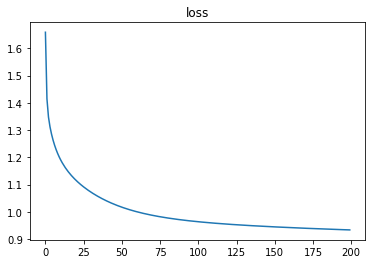

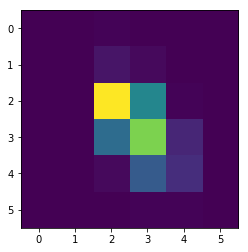

In [59]:
with tf.Session() as sess:
    features = tf.placeholder("float", (None, 11))
    labels = tf.placeholder("float", (None, 6))
    feedforward = FeedForwardNN(sess)
    sess.run(tf.global_variables_initializer())
    feedforward.fit(X_train, y_train)
    
    plt.figure(figsize = (6, 4))
    plt.title("loss")
    plt.plot(range(len(feedforward.training_loss)), feedforward.training_loss)
    
    plt.figure(figsize = (4, 4))
    y_pred = feedforward.predict(X_test)
    print("Accuracy", accuracy_score(y_test, y_pred))
    plt.imshow(confusion_matrix(y_test, y_pred))

## Multilayer perceptron (MLP)

In [64]:
class MultilayerPerceptron(FeedForwardNN):
    def __init__(self, session, features, labels):
        # Two-layer FeedForwardNN
        hidden_layer = tf.layers.dense(features, 10, tf.tanh)
        hidden_layer2 = tf.layers.dense(hidden_layer, 8, tf.tanh)
        hidden_layer3 = tf.layers.dense(hidden_layer2, 8, tf.sigmoid)
        predictions = tf.layers.dense(hidden_layer3, 6)

        # Loss function
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=predictions))

        # An optimizer defines the operation for updating parameters within the model.
        optimizer = tf.train.AdamOptimizer()

        # Training is defined as minimizing the loss function using gradient descent.
        training = optimizer.minimize(loss)
        
        self.context = [session, training, loss, predictions]
        
    def fit(self, X_train, y_train, N_BATCH=32):
        sess, training, loss, _  = self.context
        label_encoding=LabelBinarizer()
        label_encoding.fit(y)
        
        training_loss = []
        for epoch in range(500):
            epoch_loss = []
            for i in range(0, X_train.shape[0], N_BATCH):
                _, batch_loss = sess.run([training, loss], feed_dict={
                    features: X_train[i:i+N_BATCH],
                    labels: label_encoding.transform(y_train[i:i+N_BATCH])
                })
                epoch_loss.append(batch_loss)
            training_loss.append(np.mean(epoch_loss))
        self.training_loss = training_loss
        self.label_encoding = label_encoding

accuracy 0.635


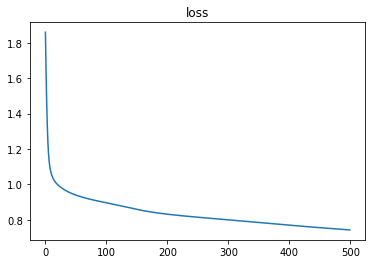

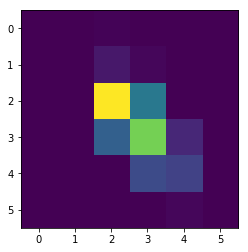

In [65]:
with tf.Session() as sess:
    features = tf.placeholder("float", (None, 11))
    labels = tf.placeholder("float", (None, 6))
    mlp = MultilayerPerceptron(sess, features, labels)
    sess.run(tf.global_variables_initializer())
    mlp.fit(X_train, y_train)
    
    plt.figure(figsize=(6,4))
    plt.title('loss')
    plt.plot(range(len(mlp.training_loss)), mlp.training_loss)
    
    plt.figure(figsize=(4,4))
    y_pred = mlp.predict(X_test)
    print('accuracy', accuracy_score(y_test, y_pred))
    plt.imshow(confusion_matrix(y_test, y_pred))